# Course Project

In [1]:
import numpy as np
import scipy.stats
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

import pymc3 as pm
import arviz as az
import scipy.stats as stats
from scipy.stats import logistic

pd.set_option('max_columns', None)

This [data](https://www.kaggle.com/sjleshrac/airlines-customer-satisfaction) given by an airline organization (the actual name was replaced due to some purposes).  

The feedback of customers on various context and their flight data has been consolidated.
The main purpose of this dataset is to predict wheather a future customer would be satisfied with the company's servise given the details of the other parameters values.  

The target variable is binary categorical (satisfied or dissatisfied). The variables either numerical or categorical.

In [2]:
data = pd.read_csv('Invistico_Airline.csv')
data.head(5)

,satisfaction,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,Gate location,Inflight wifi service,Inflight entertainment,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes
0,satisfied,Female,Loyal Customer,65,Personal Travel,Eco,265,0,0,0,2,2,4,2,3,3,0,3,5,3,2,0,0.0
1,satisfied,Male,Loyal Customer,47,Personal Travel,Business,2464,0,0,0,3,0,2,2,3,4,4,4,2,3,2,310,305.0
2,satisfied,Female,Loyal Customer,15,Personal Travel,Eco,2138,0,0,0,3,2,0,2,2,3,3,4,4,4,2,0,0.0
3,satisfied,Female,Loyal Customer,60,Personal Travel,Eco,623,0,0,0,3,3,4,3,1,1,0,1,4,1,3,0,0.0
4,satisfied,Female,Loyal Customer,70,Personal Travel,Eco,354,0,0,0,3,4,3,4,2,2,0,2,4,2,5,0,0.0


Let's look closely at the number of values in each of the columns. As we can see almost all of the variables have no missing values, except the last one.  
But even there the number of passes is insignificant, so we can safely put mean of the column in their place.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129880 entries, 0 to 129879
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   satisfaction                       129880 non-null  object 
 1   Gender                             129880 non-null  object 
 2   Customer Type                      129880 non-null  object 
 3   Age                                129880 non-null  int64  
 4   Type of Travel                     129880 non-null  object 
 5   Class                              129880 non-null  object 
 6   Flight Distance                    129880 non-null  int64  
 7   Seat comfort                       129880 non-null  int64  
 8   Departure/Arrival time convenient  129880 non-null  int64  
 9   Food and drink                     129880 non-null  int64  
 10  Gate location                      129880 non-null  int64  
 11  Inflight wifi service              1298

Also we have 5 categorical variables in the dataset including the target variable. 4 of them (with 2 unique values each) we simply encode by 0s and 1s.  
And for 1 variable (with 3 unique values) we apply the dummy encoding. Let's wrap this procedure into a function and apply it to our dataset.

In [4]:
def preprocess_inputs(df):
    df = df.copy()
    
    # Fill missing arrival delay values with column mean
    df['Arrival Delay in Minutes'] = df['Arrival Delay in Minutes'].fillna(df['Arrival Delay in Minutes'].mean())
    
    # Binary encoding
    df['Gender'] = df['Gender'].replace({
        'Female': 0,
        'Male': 1
    })
    df['Customer Type'] = df['Customer Type'].replace({
        'disloyal Customer': 0,
        'Loyal Customer': 1
    })
    df['Type of Travel'] = df['Type of Travel'].replace({
        'Personal Travel': 0,
        'Business travel': 1
    })
    df['satisfaction'] = df['satisfaction'].replace({
        'dissatisfied': 0,
        'satisfied': 1
    })
    
    # One-hot encoding
    flight_class_dummies = pd.get_dummies(df['Class'], prefix='Flight_class')
    df = pd.concat([df, flight_class_dummies], axis=1)
    df = df.drop('Class', axis=1)
    
    return df


In [5]:
data = preprocess_inputs(data)
data

,satisfaction,Gender,Customer Type,Age,Type of Travel,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,Gate location,Inflight wifi service,Inflight entertainment,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes,Flight_class_Business,Flight_class_Eco,Flight_class_Eco Plus
0,1,0,1,65,0,265,0,0,0,2,2,4,2,3,3,0,3,5,3,2,0,0.0,0,1,0
1,1,1,1,47,0,2464,0,0,0,3,0,2,2,3,4,4,4,2,3,2,310,305.0,1,0,0
2,1,0,1,15,0,2138,0,0,0,3,2,0,2,2,3,3,4,4,4,2,0,0.0,0,1,0
3,1,0,1,60,0,623,0,0,0,3,3,4,3,1,1,0,1,4,1,3,0,0.0,0,1,0
4,1,0,1,70,0,354,0,0,0,3,4,3,4,2,2,0,2,4,2,5,0,0.0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129875,1,0,0,29,0,1731,5,5,5,3,2,5,2,2,3,3,4,4,4,2,0,0.0,0,1,0
129876,0,1,0,63,0,2087,2,3,2,4,2,1,1,3,2,3,3,1,2,1,174,172.0,1,0,0
129877,0,1,0,69,0,2320,3,0,3,3,3,2,2,4,4,3,4,2,3,2,155,163.0,0,1,0
129878,0,1,0,66,0,2450,3,2,3,2,3,2,2,3,3,2,3,2,1,2,193,205.0,0,1,0


The Boxplots below will help us to understand the spread of each variable in the dataset.

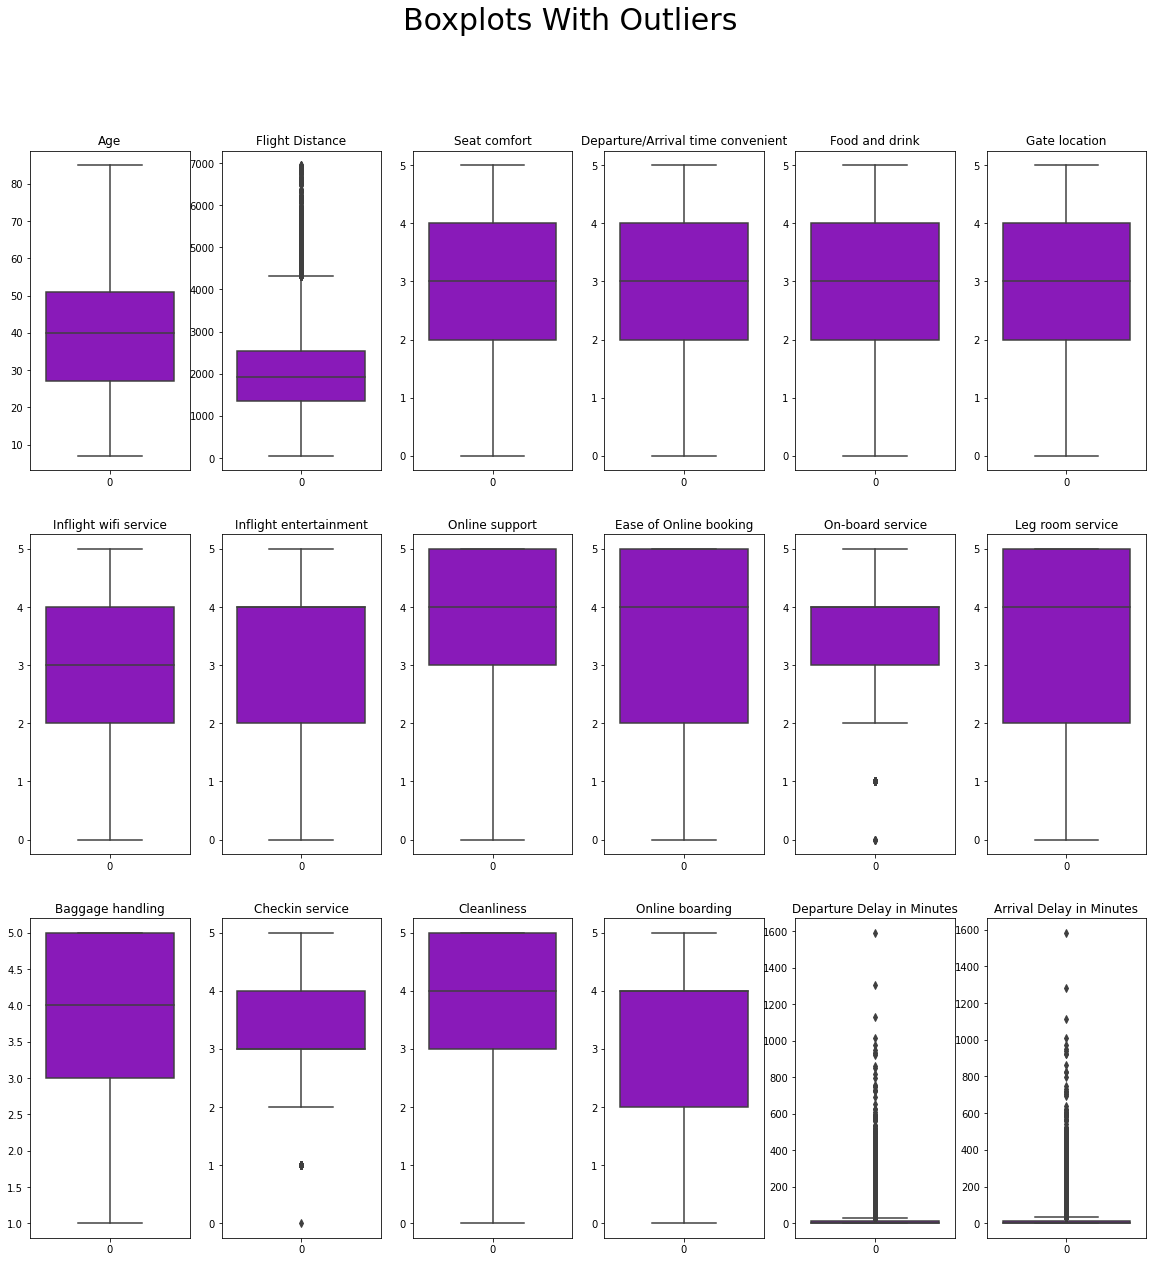

In [6]:
eda_df = data.drop('satisfaction', axis=1).copy()
nonbinary_columns = [column for column in eda_df.columns if len(eda_df[column].unique()) > 2]

plt.figure(figsize=(20, 20))

for i, column in enumerate(nonbinary_columns):
    plt.subplot(3, 6, i + 1)
    sns.boxplot(data=eda_df[column], color='darkviolet')
    plt.title(column)

plt.suptitle("Boxplots With Outliers", size=30)
plt.show()

The quick visual examination gives some variables with large outliers. The function below deals with these data.
The easiest and most proper way is just to drop these observations from the dataset. Otherwise they may confuse the models.

In [7]:
def remove_outliers(df, columns, threshold):
    df = df.copy()
    
    # Calculate the lower and upper bounds on the Z distribution given a threshold value
    lower_bound = scipy.stats.norm.ppf(q=(threshold / 2), loc=0, scale=1)
    upper_bound = scipy.stats.norm.ppf(q=1 - (threshold / 2), loc=0, scale=1)
    
    # Calculate z-scores of every example in the columns specified
    outlier_df = df.loc[:, columns].copy()
    zscores = pd.DataFrame(scipy.stats.zscore(outlier_df, axis=0), index=outlier_df.index, columns=outlier_df.columns)
    
    # Get boolean arrays denoting the outlier examples
    lower_outliers = (zscores < lower_bound).any(axis=1)
    upper_outliers = (zscores >= upper_bound).any(axis=1)
    
    # Get indicies of all outlier examples
    outliers = df[pd.concat([lower_outliers, upper_outliers], axis=1).any(axis=1)].index
    
    # Drop the outliers
    df = df.drop(outliers, axis=0).reset_index(drop=True)
    print(len(outliers), "examples dropped.")
    
    return df

41258 examples dropped.


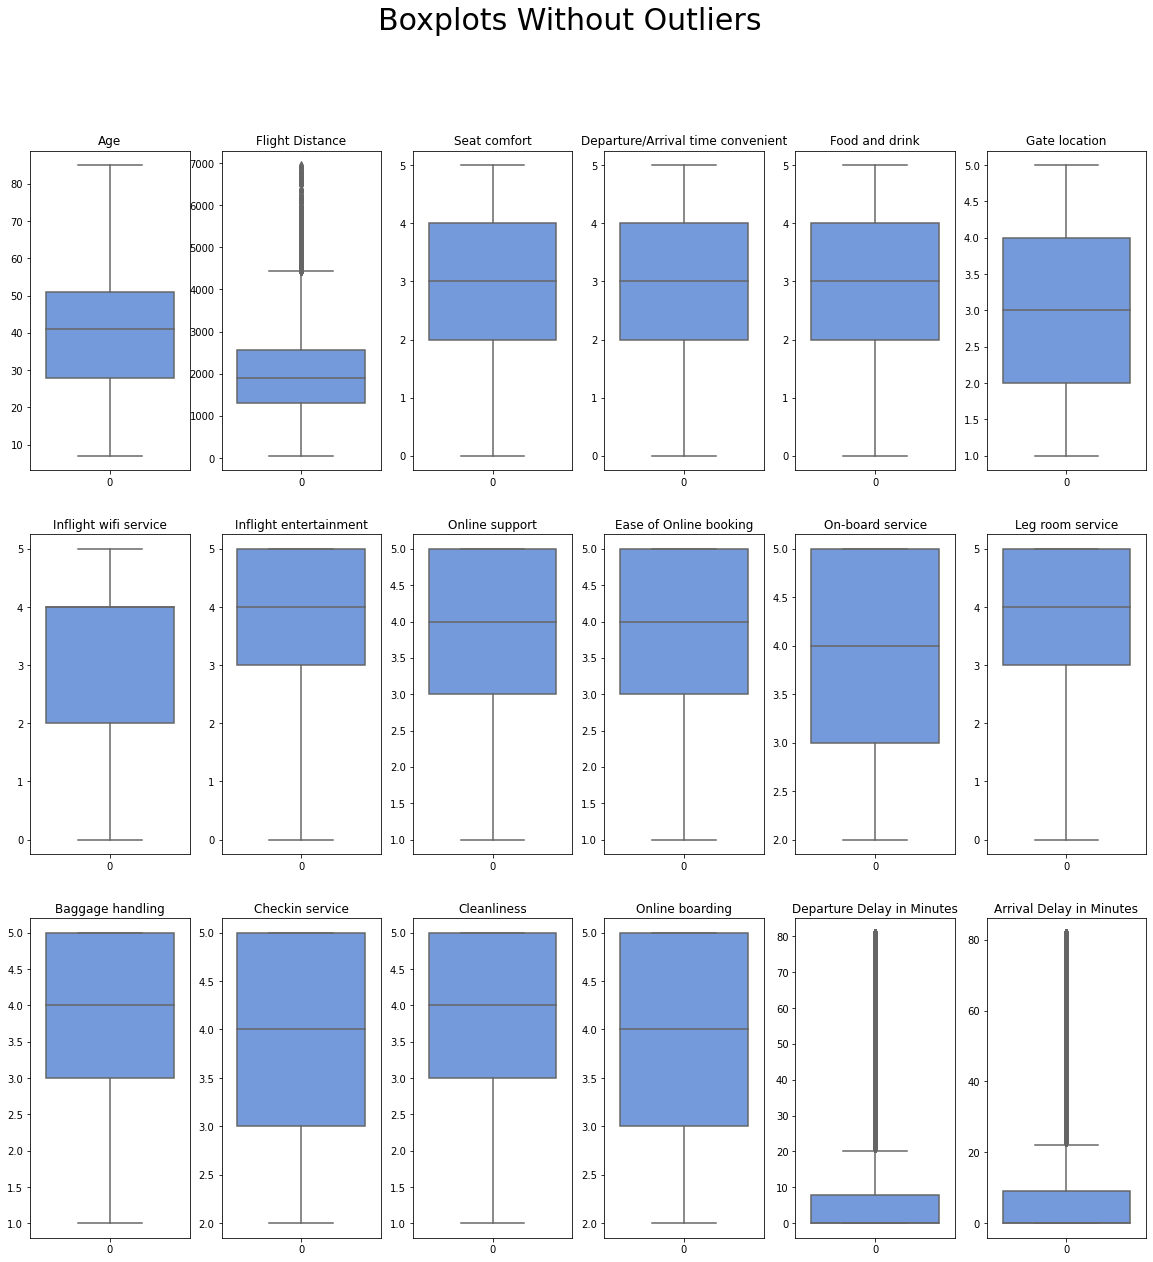

In [8]:
outliers_df = remove_outliers(
    df=data,
    columns=[
        'On-board service',
        'Checkin service',
        'Departure Delay in Minutes',
        'Arrival Delay in Minutes',
        'Online boarding'
    ],
    threshold=0.08
)

plt.figure(figsize=(20, 20))

for i, column in enumerate(nonbinary_columns):
    plt.subplot(3, 6, i + 1)
    sns.boxplot(data=outliers_df[column], color='cornflowerblue')
    plt.title(column)

plt.suptitle("Boxplots Without Outliers", size=30)
plt.show()


To check the accuracy of predictions, we split the dataset into training and test samples using the corresponding function from scikit-learn library.  
Also it is important to scale up the variables making their mean equals to 0 and deviation to 1.

In [9]:
train_df, test_df = train_test_split(data, train_size=0.7, shuffle=True, random_state=1)

train_df = remove_outliers(
            train_df,
            columns=[
                'On-board service',
                'Checkin service',
                'Departure Delay in Minutes',
                'Arrival Delay in Minutes'
            ],
            threshold=0.05
        )

# Split df into X and y
y_train = train_df['satisfaction']
y_test = test_df['satisfaction']
X_train = train_df.drop('satisfaction', axis=1)
X_test = test_df.drop('satisfaction', axis=1)
    
# Scale X
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)

print('X_train.shape = ', X_train.shape)
print('X_test.shape = ', X_test.shape)

4047 examples dropped.
X_train.shape =  (86869, 24)
X_test.shape =  (38964, 24)


# Simple logistic regression

Before going directly to MCMC, let's check the accuracy of a simple logistic regression with the considering samples. 

In [10]:
model1 = LogisticRegression()
model1.fit(X_train_scaled, y_train)

print("Test Accuracy: {:.3f}%".format(model1.score(X_test_scaled, y_test) * 100))

Test Accuracy: 83.580%


# MCMC Approach

The math formulation of the model looks as follows:

$$
t_i | x_i, \mathbf w \sim \mathrm{Be}(\theta(\mathbf x_i))
\\
\theta(x) = \mathrm{logit}(\mathbf w^T \mathbf x)
\\
\mathbf w_j \sim  \mathcal N(0, S_j)
$$

Rescaling the variables manually since we need means and scaling values later while predicting test sample.

In [11]:
# normalize data and append ones
x_means = X_train.mean(axis=0)
x_scales = X_train.std(axis=0)
zX = ((X_train-x_means)/x_scales)
zX = np.hstack([np.ones(shape=(zX.shape[0], 1)), zX])
zX.shape

(86869, 25)

Build our model and present it visually. Recall that now parameters we have by one more than it was before adding
the bias column.

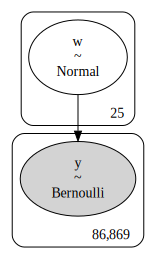

In [12]:
with pm.Model() as model:
    w = pm.Normal('w', mu=0, sd=np.array([10] + [2] * X_train.shape[1]), shape=(X_train.shape[1] + 1))
    theta = pm.invlogit(pm.math.dot(w, zX.T))
    outputs = pm.Bernoulli('y', theta, observed=y_train)
pm.model_to_graphviz(model)

Due to the large dataset and number of parameters the following proccess is really time consuming.

In [13]:
with model:
    trace = pm.sample(draws=1000, tune=500, chains=2, cores=2,
                      return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [w]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 11064 seconds.
The acceptance probability does not match the target. It is 0.8870077592535356, but should be close to 0.8. Try to increase the number of tuning steps.


/home/batyr/.local/lib/python3.8/site-packages/arviz/plots/traceplot.py:197: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (25), generating only 20 plots
  warnings.warn(


array([[<AxesSubplot:title={'center':'w\n0'}>,
        <AxesSubplot:title={'center':'w\n0'}>],
       [<AxesSubplot:title={'center':'w\n1'}>,
        <AxesSubplot:title={'center':'w\n1'}>],
       [<AxesSubplot:title={'center':'w\n2'}>,
        <AxesSubplot:title={'center':'w\n2'}>],
       [<AxesSubplot:title={'center':'w\n3'}>,
        <AxesSubplot:title={'center':'w\n3'}>],
       [<AxesSubplot:title={'center':'w\n4'}>,
        <AxesSubplot:title={'center':'w\n4'}>],
       [<AxesSubplot:title={'center':'w\n5'}>,
        <AxesSubplot:title={'center':'w\n5'}>],
       [<AxesSubplot:title={'center':'w\n6'}>,
        <AxesSubplot:title={'center':'w\n6'}>],
       [<AxesSubplot:title={'center':'w\n7'}>,
        <AxesSubplot:title={'center':'w\n7'}>],
       [<AxesSubplot:title={'center':'w\n8'}>,
        <AxesSubplot:title={'center':'w\n8'}>],
       [<AxesSubplot:title={'center':'w\n9'}>,
        <AxesSubplot:title={'center':'w\n9'}>],
       [<AxesSubplot:title={'center':'w\n10'}>,
  

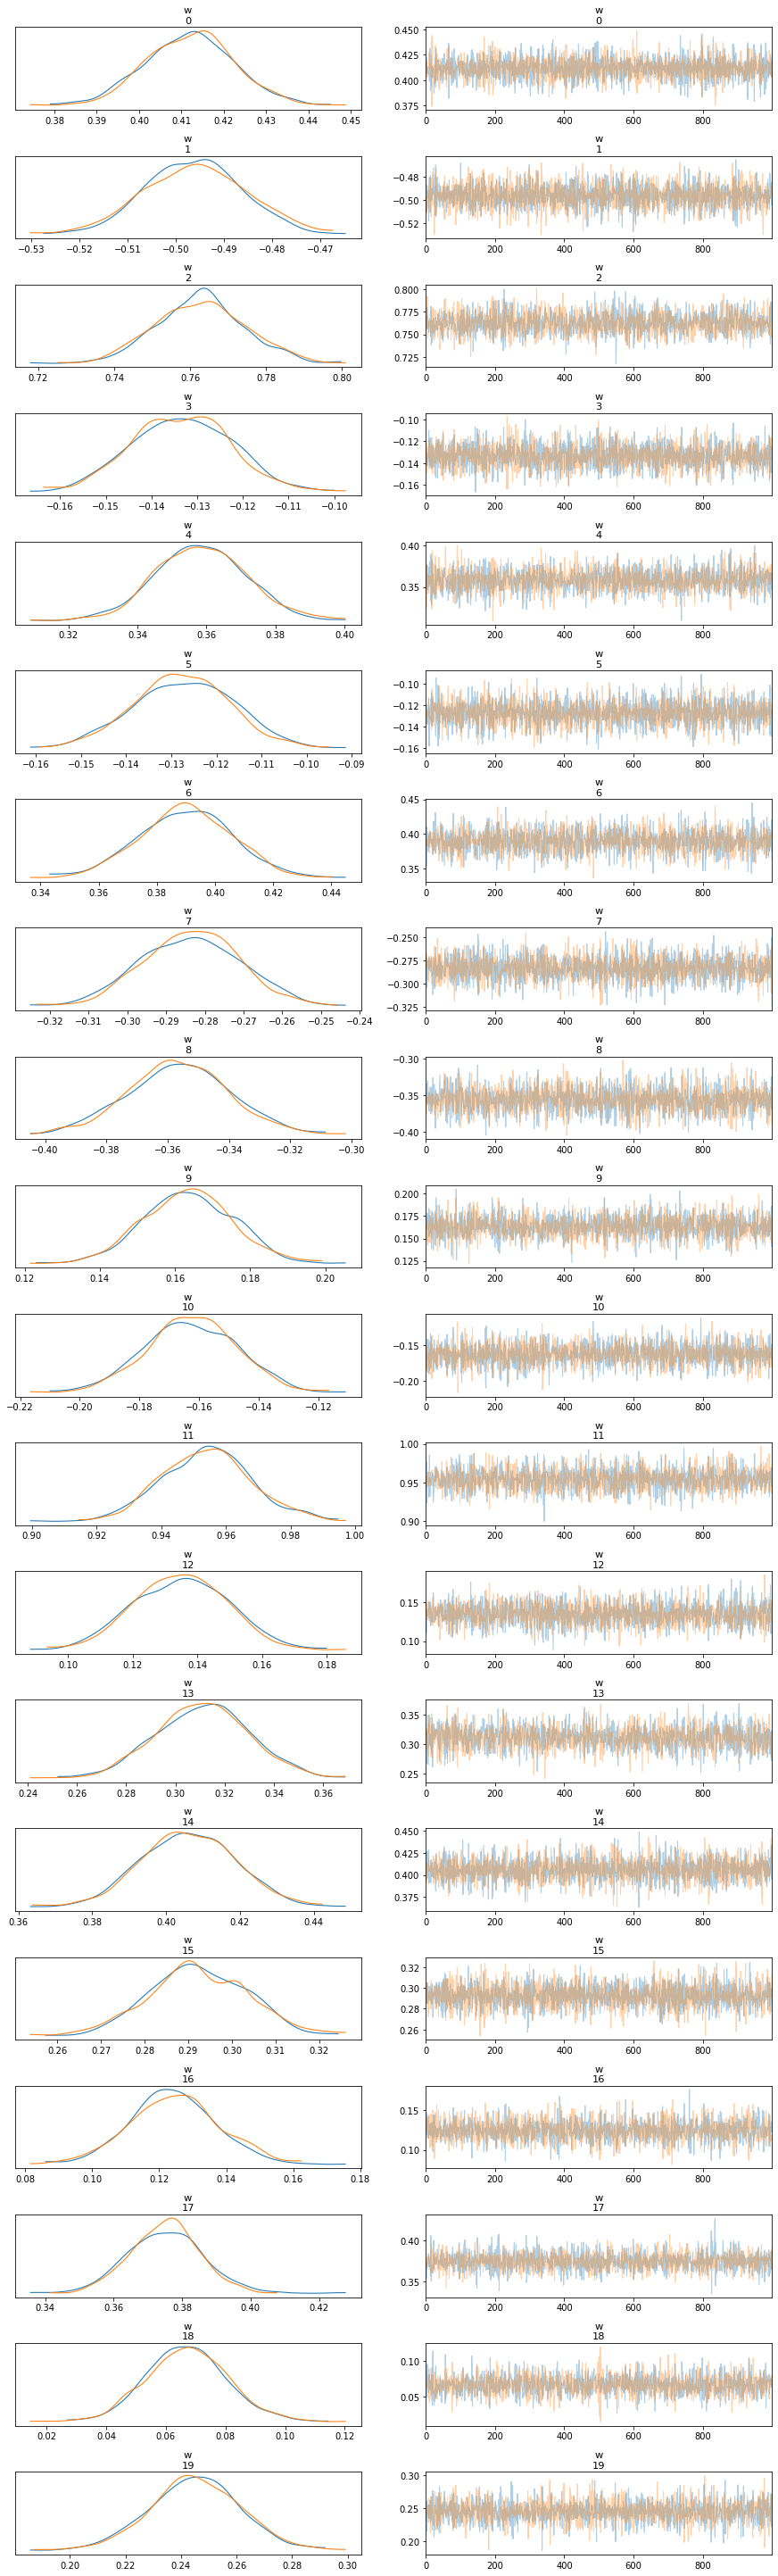

In [14]:
az.plot_trace(trace, compact=False)

As we can see each pair of chains are almost overlapping for each parameter, which gives us quite reliable results. The corresponding autocorrelation and some statistical measurements:

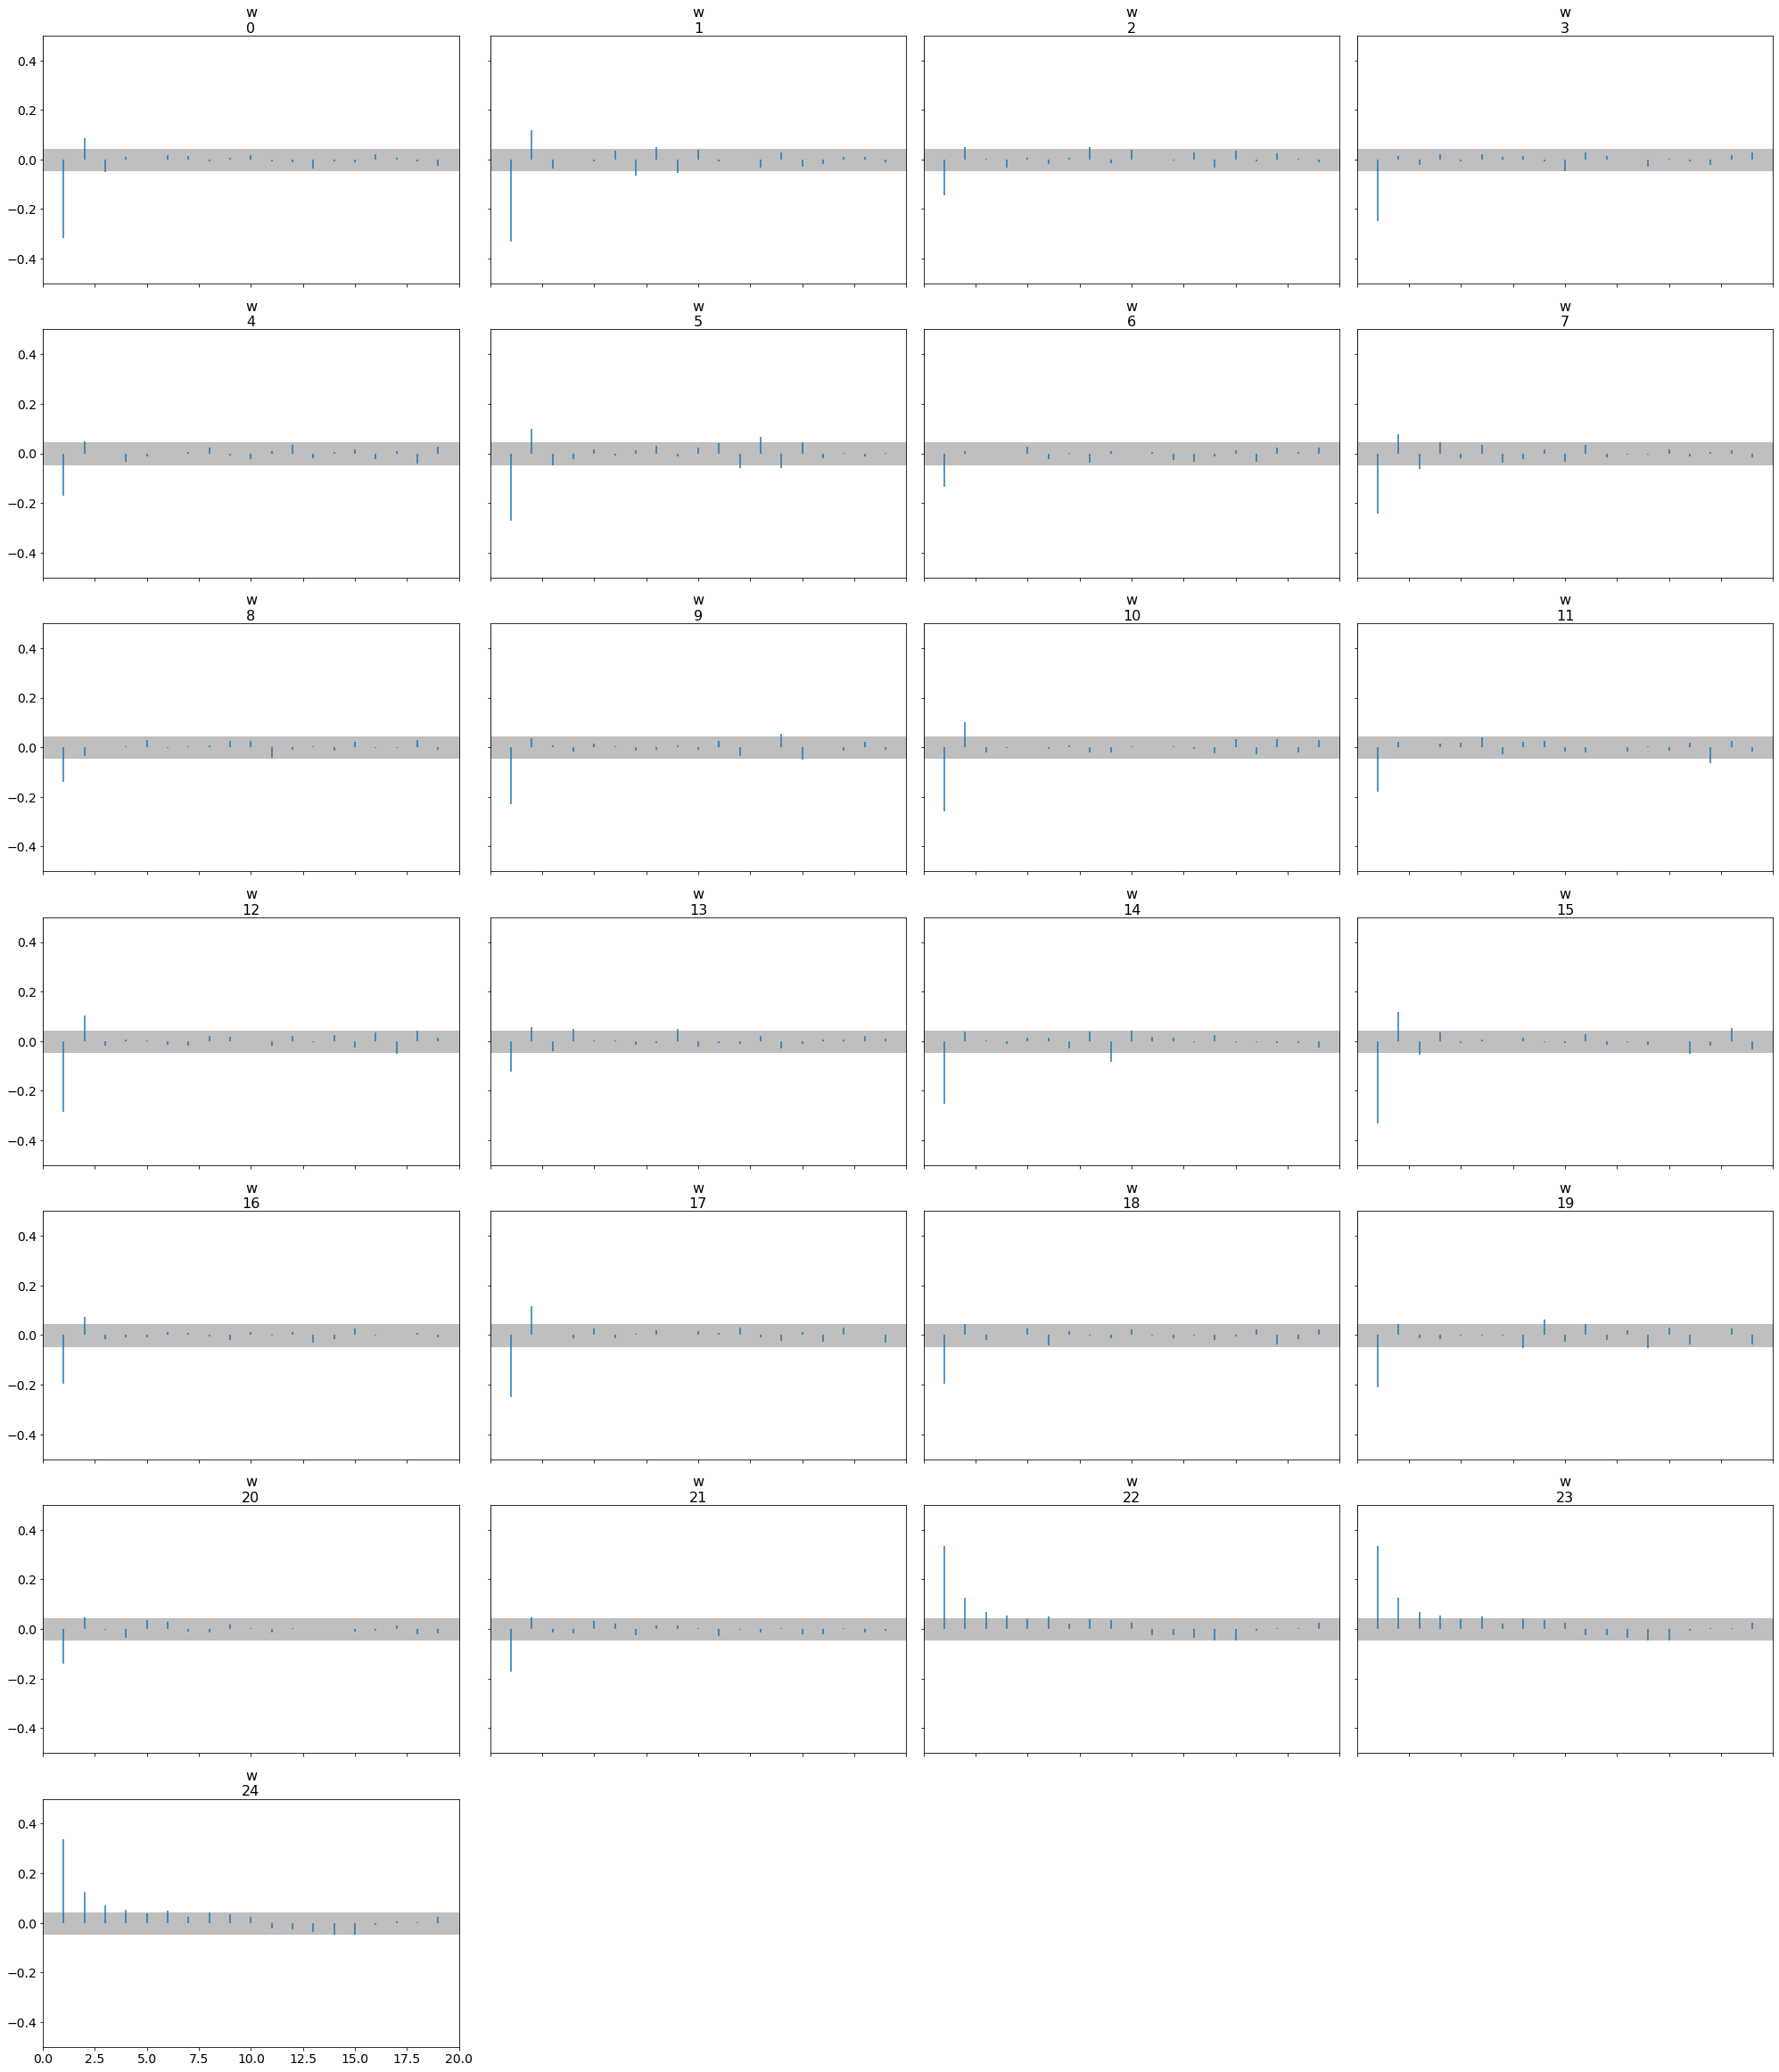

In [15]:
az.plot_autocorr(trace, max_lag=20, combined=True)
plt.ylim([-0.5, 0.5]);

In [16]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
w[0],0.412,0.011,0.392,0.431,0.000,0.000,4401.0,1521.0,1.00
w[1],-0.496,0.010,-0.515,-0.476,0.000,0.000,4119.0,1462.0,1.00
w[2],0.763,0.012,0.742,0.785,0.000,0.000,2494.0,1701.0,1.01
w[3],-0.133,0.011,-0.154,-0.115,0.000,0.000,3861.0,1613.0,1.00
w[4],0.358,0.013,0.335,0.384,0.000,0.000,2724.0,1571.0,1.00
w[5],-0.127,0.011,-0.149,-0.107,0.000,0.000,3665.0,1503.0,1.00
w[6],0.390,0.016,0.359,0.418,0.000,0.000,2694.0,1554.0,1.00
w[7],-0.284,0.013,-0.306,-0.258,0.000,0.000,3387.0,1557.0,1.00
w[8],-0.356,0.017,-0.388,-0.325,0.000,0.000,2781.0,1501.0,1.00
w[9],0.164,0.012,0.142,0.187,0.000,0.000,3220.0,1576.0,1.00


The maximum $\hat{R}$ out of the parameters is 1.01 -- good estimation of chains convergence.  
Posterior distribution of parameters:

array([[<AxesSubplot:title={'center':'w\n0'}>,
        <AxesSubplot:title={'center':'w\n1'}>,
        <AxesSubplot:title={'center':'w\n2'}>,
        <AxesSubplot:title={'center':'w\n3'}>],
       [<AxesSubplot:title={'center':'w\n4'}>,
        <AxesSubplot:title={'center':'w\n5'}>,
        <AxesSubplot:title={'center':'w\n6'}>,
        <AxesSubplot:title={'center':'w\n7'}>],
       [<AxesSubplot:title={'center':'w\n8'}>,
        <AxesSubplot:title={'center':'w\n9'}>,
        <AxesSubplot:title={'center':'w\n10'}>,
        <AxesSubplot:title={'center':'w\n11'}>],
       [<AxesSubplot:title={'center':'w\n12'}>,
        <AxesSubplot:title={'center':'w\n13'}>,
        <AxesSubplot:title={'center':'w\n14'}>,
        <AxesSubplot:title={'center':'w\n15'}>],
       [<AxesSubplot:title={'center':'w\n16'}>,
        <AxesSubplot:title={'center':'w\n17'}>,
        <AxesSubplot:title={'center':'w\n18'}>,
        <AxesSubplot:title={'center':'w\n19'}>],
       [<AxesSubplot:title={'center':'w\n20'}

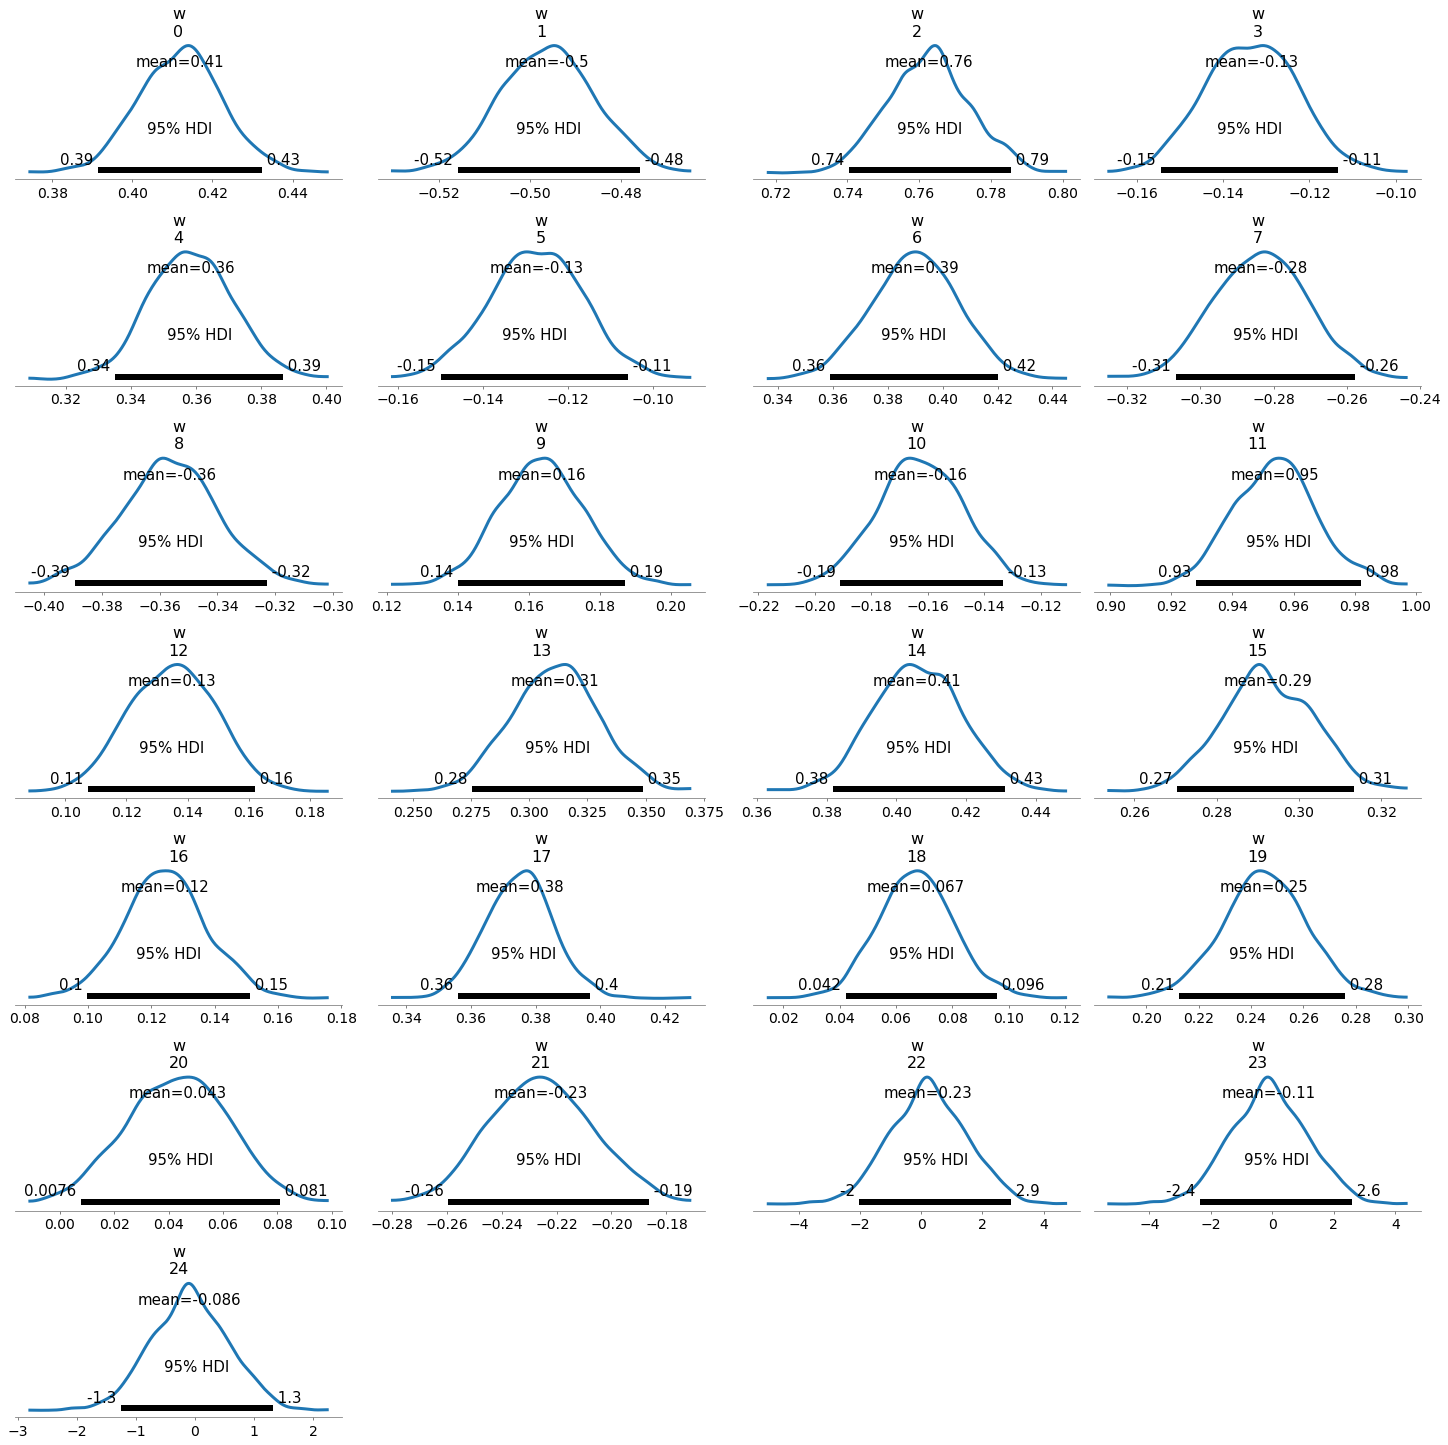

In [17]:
az.plot_posterior(trace, hdi_prob=0.95, figsize=(20,20), lw=3)

array([<AxesSubplot:title={'center':'95.0% HDI'}>,
       <AxesSubplot:title={'center':'ess'}>,
       <AxesSubplot:title={'center':'r_hat'}>], dtype=object)

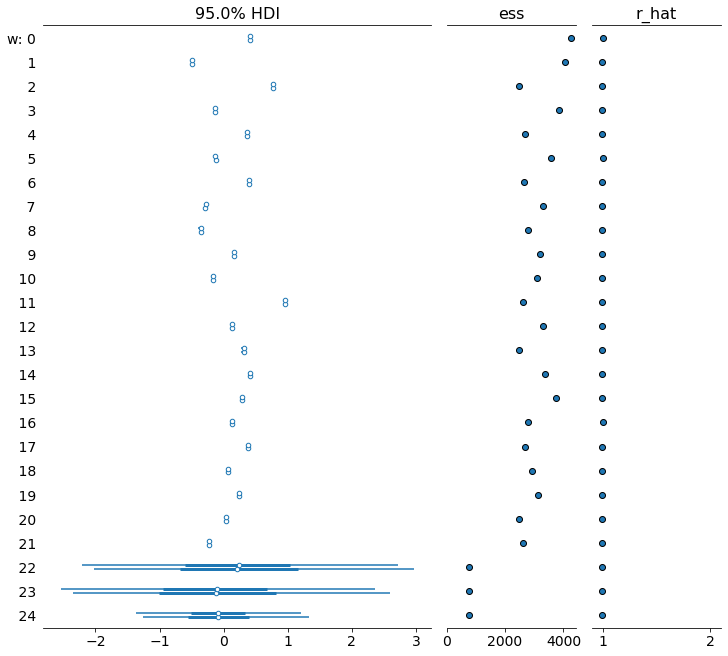

In [18]:
az.plot_forest(trace, hdi_prob=0.95,
               r_hat=True, ess=True)

Since we run 2 Markov Chains, there are 2 confidence intervals for each parameter.

Let's transform our weights back to the initial scale by using the saved mean and scaling values.

In [19]:
w_trace = list()
for i in range(X_test.shape[1]+1):
    w_trace.append(trace.posterior['w'][...,i].values.reshape(-1))
    
tmp = 0
for i in range(1, len(w_trace)):
    tmp += x_means[i-1] / x_scales[i-1] * w_trace[i]
w_trace[0] -= tmp

for i in range(1, len(w_trace)):
    w_trace[i] /= x_scales[i-1]

w_trace = np.stack([k for k in w_trace], axis=-1)
w_trace.shape

(2000, 25)

For the purpose of interest we are going to check how confident our ensemble for different observations and also
compare the outputs with true target values. Randomly selecting 12 observations from the test sample, we are building histogram plots for each of the outputs.

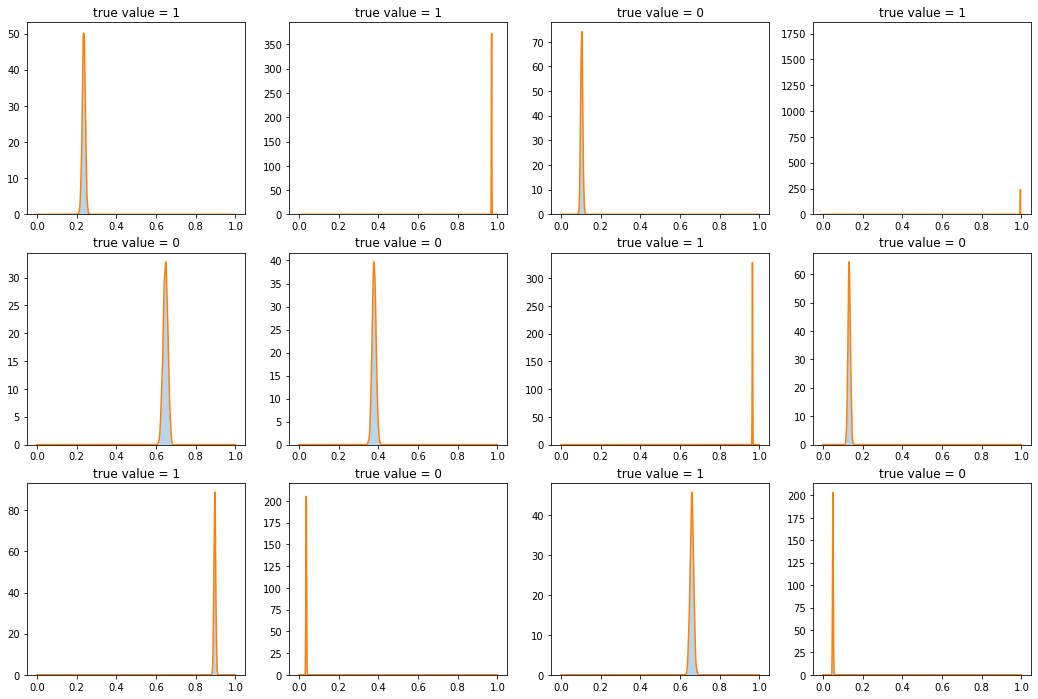

In [20]:
from random import randint
fig, axs = plt.subplots(3, 4, figsize=(18, 12))

for i in range(3):
    for j in range(4):
        obs = randint(0, len(y_test))
        
        x_new = np.array(X_test.iloc[obs, :].values)
        x_new = np.concatenate([[1], x_new])
        prob = logistic.cdf(w_trace.dot(x_new))
        
        axs[i, j].title.set_text(f'true value = {y_test.values[obs]}')
        axs[i, j].hist(prob, density=True, alpha=0.3)
        kde = stats.gaussian_kde(prob)
        xx = np.linspace(0, 1, 1000)
        axs[i, j].plot(xx, kde(xx))

The overal model seems to be really confident in its predictions.  
However our primary goal is to make predictions for the whole test sample. We will use the help of logistic.cdf function.

In [21]:
from tqdm import trange

preds = np.zeros(len(y_test))
for i in trange(len(y_test)):
    x_new = np.array(X_test.iloc[i, :].values)
    x_new = np.concatenate([[1], x_new])
    preds[i] = logistic.cdf(w_trace.dot(x_new)).mean()

preds_bin = np.zeros(len(y_test))
for i in range(len(y_test)):
    if preds[i] >= 0.5:
        preds_bin[i] = 1
    else:
        preds_bin[i] = 0

sum = 0
for i in range(len(y_test)):
    sum += preds_bin[i] == y_test.values[i]
print("Test Accuracy: {:.3f}%".format(sum / len(y_test) * 100))

100%|██████████| 38964/38964 [01:00<00:00, 639.31it/s] 


Test Accuracy: 83.582%


The results from the described MCMC approach and the simple logistic model are quite the same. Our model worked better only by thousands of a percent.  